<a href="https://colab.research.google.com/github/taerd/DSIntro/blob/master/Bugs_are_noticed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Label Encoding or Ordinal Encoding
import category_encoders as ce

In [ ]:
df = pd.read_csv('https://stepik.org/media/attachments/course/4852/invasion.csv')

In [ ]:
df.head()

,class,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,transport,2.190672,6.716633,62.168208,0.347465,158221,44.932446
1,transport,3.453276,8.995909,62.994707,0.590094,385972,41.568300
2,transport,2.432994,6.938691,62.245807,0.329288,446482,40.123467
3,fighter,6.083763,3.019459,18.474555,0.174738,210125,11.384865
4,fighter,12.876769,2.452950,195.805771,0.150446,23109,11.328806


In [ ]:
df.isnull().sum()

class                 0
g_reflection          0
i_reflection          0
speed                 0
brightness            0
time_of_observance    0
volume                0
dtype: int64

In [ ]:
df['class'].unique()

array(['transport', 'fighter', 'cruiser'], dtype=object)

In [ ]:
encoder = ce.OrdinalEncoder(cols = ['class'], return_df  = True, \
                           mapping = [{'col' : 'class','mapping' : {'transport' : 1 , 'fighter' : 2 , 'cruiser' : 3}}])

In [ ]:
df_transformed = encoder.fit_transform(df)

d:\code\python interpritator\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
df = df_transformed

In [ ]:
# отбор целевой переменной и выборки
y = df['class']
X = df.drop(['class'],axis =1)

In [ ]:
df.corr()

,class,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
class,1.000000,0.863206,-0.055665,0.464071,-0.072624,-0.007152,0.652622
g_reflection,0.863206,1.000000,-0.182375,0.465410,-0.219170,-0.012570,0.448030
i_reflection,-0.055665,-0.182375,1.000000,-0.434940,0.715616,-0.020922,0.518784
speed,0.464071,0.465410,-0.434940,1.000000,-0.552377,-0.027782,-0.105198
brightness,-0.072624,-0.219170,0.715616,-0.552377,1.000000,0.013765,0.642957
time_of_observance,-0.007152,-0.012570,-0.020922,-0.027782,0.013765,1.000000,0.026136
volume,0.652622,0.448030,0.518784,-0.105198,0.642957,0.026136,1.000000


<AxesSubplot:>

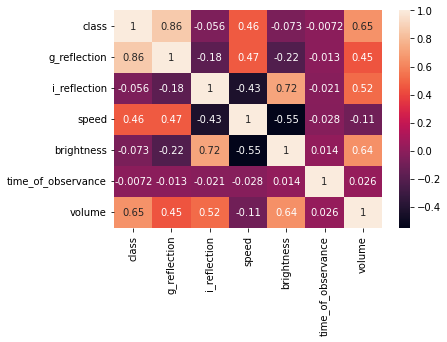

In [ ]:
# матрица корреляции признаков
# простой вариант
sns.heatmap(df.corr(),annot = True)

In [ ]:
def correlation_map(data, method):
    
    corr = data.corr(method)
    ix = corr.sort_values('class', ascending=False,).index
    df_sorted_by_correlation = data.loc[:, ix]
    
    corr = df_sorted_by_correlation.corr(method)
    plt.subplots(figsize=(18,14))
    with sns.axes_style("white"):
        # display a correlation heatmap
        ax = sns.heatmap(corr, annot=True)
    plt.show()

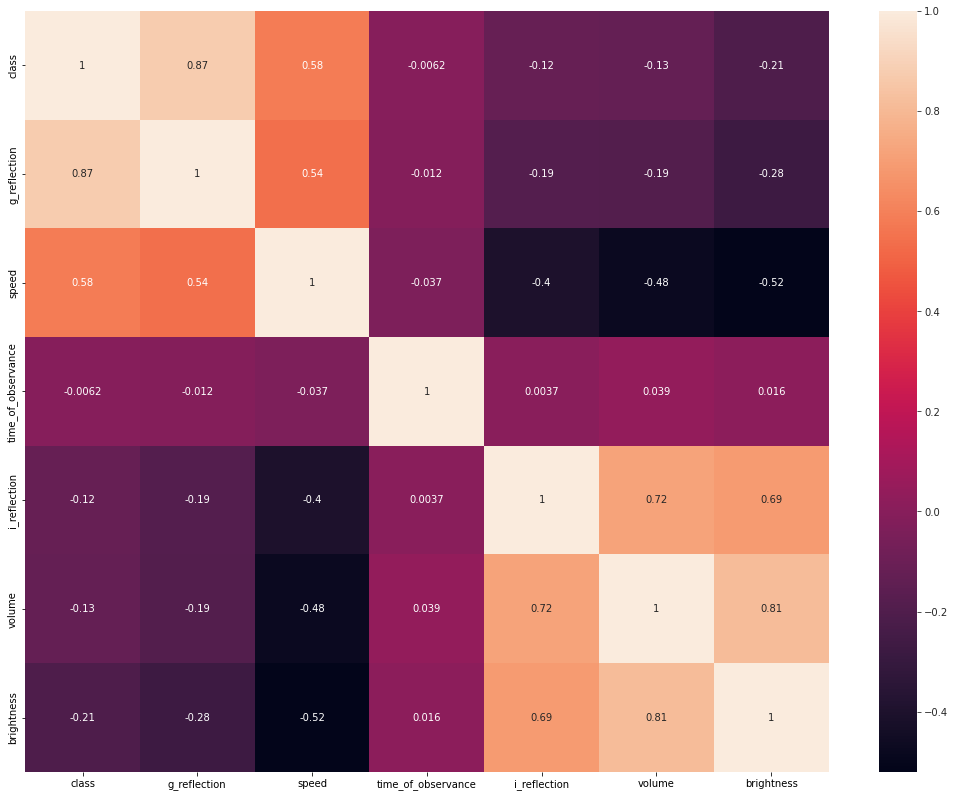

In [ ]:
# с классом наибольшую корреляцию имеет g_reflection
# сильно корреллированные признаки следует убрать для получения точных результатов
# в данном случае  brightness&volume и тд..
correlation_map(df, method="spearman")

In [ ]:
# выбор наилучших параметров для модели:
# Оценка взаимной информации для дискретной целевой переменной.

# Взаимная информация (MI)  между двумя случайными величинами является неотрицательным значением,
# которое измеряет зависимость между переменными. 
# Она равна нулю тогда и только тогда, когда две случайные величины независимы, 
# а более высокие значения означают более высокую зависимость.

# Функция опирается на непараметрические методы,
# основанные на оценке энтропии из k-ближайших расстояний соседей
from sklearn.feature_selection import mutual_info_classif , SelectKBest


In [ ]:
mutual_info_classif(X,y,random_state = 12)

array([0.69593867, 0.68042831, 0.63882368, 0.82214949, 0.        ,
       1.00214309])

In [ ]:
def SelectKBestCustomized(X,y, k, score_func):
    np.random.seed(12) # for mutual_info regression
    fs = SelectKBest(score_func=score_func, k=k)
    fs.fit(X, y)
    mask = fs.get_support()
    selected_features = [feature for bool, feature in zip(mask, X.columns) if bool]
    return selected_features

In [ ]:
# отбор параметров (k)
mutual_info_selection = SelectKBestCustomized(X,y, 5, mutual_info_classif)
mutual_info_selection

['g_reflection', 'i_reflection', 'speed', 'brightness', 'volume']

In [ ]:
X = X[['g_reflection', 'i_reflection', 'speed', 'brightness', 'volume']]

In [ ]:
df['class'].index

RangeIndex(start=0, stop=500, step=1)

<AxesSubplot:xlabel='class'>

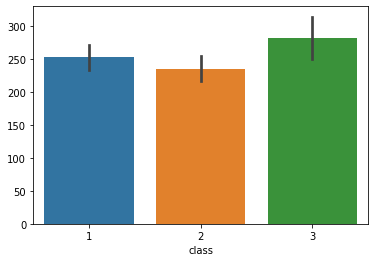

In [ ]:
# распеределение классов
sns.barplot( x= 'class' , y = df['class'].index , data = df)

In [ ]:
# обучение модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
clf_rf = RandomForestClassifier(random_state=123)

In [ ]:
params = {'n_estimators' : [5,7,9,11], \
          'max_depth' : range(1,5), \
          'min_samples_leaf' : range(1,6), \
          'min_samples_split' : range(2,9,2) }

In [ ]:
grid_search_cv_clf = GridSearchCV(clf_rf,params,cv=3,n_jobs=-1)

In [ ]:
grid_search_cv_clf.fit(X,y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 5),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 9, 2),
                         'n_estimators': [5, 7, 9, 11]})

In [ ]:
grid_search_cv_clf.best_params_

{'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 5}

In [ ]:
best_clf = grid_search_cv_clf.best_estimator_

In [ ]:
# предсказание на новых данных
test_df = pd.read_csv('https://stepik.org/media/attachments/course/4852/operative_information.csv')

In [ ]:
test_df.head()

,g_reflection,i_reflection,speed,brightness,time_of_observance,volume
0,7.516543,3.916691,513.954279,0.177247,105908,13.267224
1,4.322988,6.967689,63.752970,0.545922,277855,39.833130
2,4.595724,9.098297,62.233948,0.389201,160662,42.014556
3,2.689675,7.964869,62.475495,0.541081,162092,42.056829
4,8.075576,5.169719,336.441261,0.174757,466853,11.779813


In [ ]:
X_test = test_df[['g_reflection', 'i_reflection', 'speed', 'brightness', 'volume']]

In [ ]:
# предсказание в количествах классов новых типов кораблей
pd.Series(best_clf.predict(X_test)).value_counts()

2    675
1    595
3    230
dtype: int64

In [ ]:
# важность параметров
feature_importances = best_clf.feature_importances_

In [ ]:
feature_importances_df = pd.DataFrame({'features' : list(X) , 'feature_ratio' : feature_importances}).sort_values('feature_ratio', ascending = False)
feature_importances_df 

,features,feature_ratio
4,volume,0.422144
0,g_reflection,0.263640
3,brightness,0.136154
1,i_reflection,0.112364
2,speed,0.065698


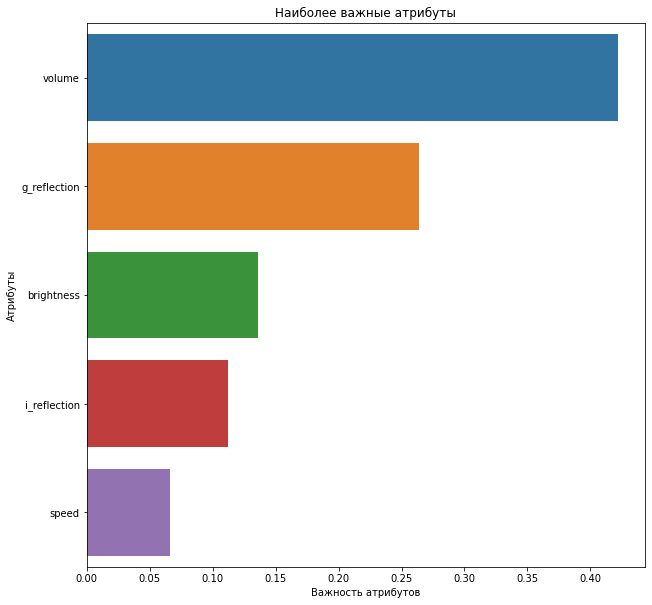

In [ ]:
plt.subplots(figsize=(10, 10))
sns.barplot(y=feature_importances_df.features, x=feature_importances_df.feature_ratio)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()

In [ ]:
# # оценки вычислений
# from sklearn import metrics

In [ ]:
# def evaluate_model(y_predict, y_test):
        
#     # Evaluate the performance of model using the test data. 
#     # Use accuracy score, precision, recall and confusion matrix as performance metrics. 
    
#     confusion_matrix_ = metrics.confusion_matrix(y_test, y_predict)
#     sns.heatmap(confusion_matrix_, annot=True, fmt="d")
#     acc = metrics.accuracy_score(y_test, y_predict)
#     prec_sc = metrics.precision_score(y_test, y_predict)
#     rec_sc = metrics.recall_score(y_test, y_predict)
#     print("Accuracy: ", acc, 
#           #"\nPrecision: ", prec_sc,
#           "\nRecall: ", rec_sc,
#           "\n\nConfusion Matrix: ")

In [ ]:
# evaluate_model(pd.Series(best_clf.predict(X)),y)

In [ ]:
# Другое задание

In [ ]:
df = pd.read_csv('https://stepik.org/media/attachments/course/4852/space_can_be_a_dangerous_place.csv')

In [ ]:
df.head()

,r,phi,peradventure_index,dustiness,black_hole_is_near,buggers_were_noticed,nearby_system_has_planemo,dangerous
0,169.1,138.0,22.3212,0.706285,0,1,1,1
1,11.1,148.0,1.4652,-0.410512,1,1,1,1
2,274.6,201.0,36.2472,0.756457,1,1,1,1
3,172.8,173.0,22.8096,0.035221,1,1,1,1
4,223.3,222.0,29.4756,0.197271,0,1,1,1


In [ ]:
df.isnull().sum()

r                            0
phi                          0
peradventure_index           0
dustiness                    0
black_hole_is_near           0
buggers_were_noticed         0
nearby_system_has_planemo    0
dangerous                    0
dtype: int64

In [ ]:
df['dangerous'].unique()

array([1, 0], dtype=int64)

In [ ]:
y = df['dangerous']
X = df.drop(['dangerous'],axis =1)

<AxesSubplot:>

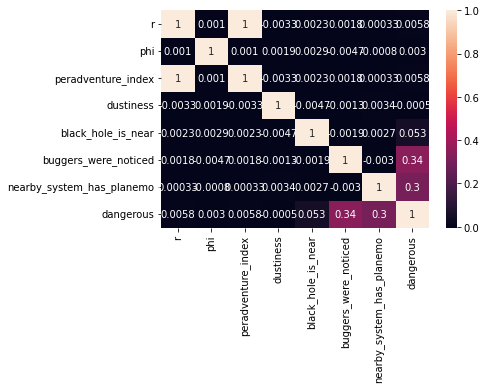

In [ ]:
sns.heatmap(df.corr(),annot = True)

In [ ]:
mutual_info_classif(X,y,random_state = 12)

array([0.        , 0.00142985, 0.00015244, 0.00064818, 0.00256087,
       0.05540907, 0.04220853])

In [ ]:
mutual_info_selection = SelectKBestCustomized(X,y, 3, mutual_info_classif)
mutual_info_selection

['black_hole_is_near', 'buggers_were_noticed', 'nearby_system_has_planemo']

In [ ]:
X = X[['black_hole_is_near', 'buggers_were_noticed', 'nearby_system_has_planemo']]

In [ ]:
clf_rf = RandomForestClassifier(random_state=12)
params = {'n_estimators' : [5,7,9,11], \
          'max_depth' : range(1,5), \
          'min_samples_leaf' : range(1,6), \
          'min_samples_split' : range(2,9,2) }
grid_search_cv_clf = GridSearchCV(clf_rf,params,cv=3,n_jobs=-1)
grid_search_cv_clf.fit(X,y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12), n_jobs=-1,
             param_grid={'max_depth': range(1, 5),
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': range(2, 9, 2),
                         'n_estimators': [5, 7, 9, 11]})

In [ ]:
grid_search_cv_clf.best_params_

{'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 5}

In [ ]:
best_clf = grid_search_cv_clf.best_estimator_

In [ ]:
feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame({'features' : list(X) , 'feature_ratio' : feature_importances}).sort_values('feature_ratio', ascending = False)
feature_importances_df 

,features,feature_ratio
2,nearby_system_has_planemo,0.844077
1,buggers_were_noticed,0.132020
0,black_hole_is_near,0.023903


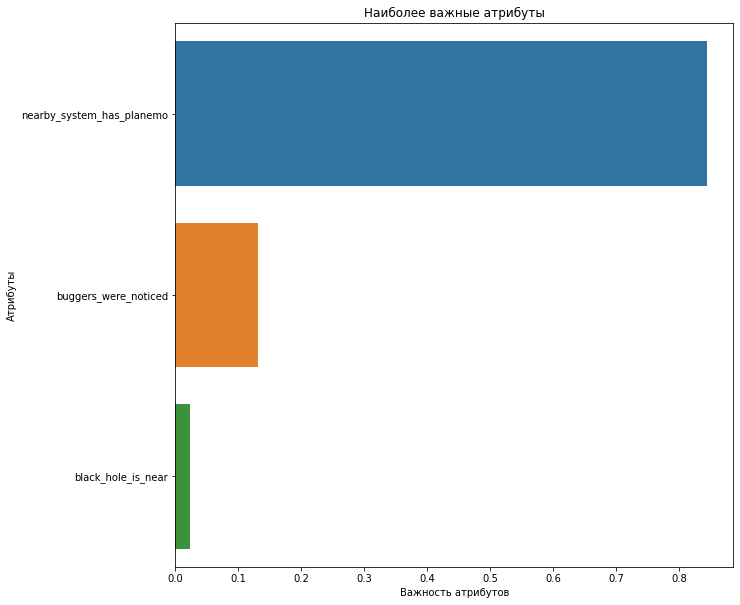

In [ ]:
plt.subplots(figsize=(10, 10))
sns.barplot(y=feature_importances_df.features, x=feature_importances_df.feature_ratio)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()